In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.signal as signal
import tkinter as tk
from tkinter import filedialog
import os
import seaborn as sns

In [18]:
main_path = r"Programowanie_Ron_wyniki_AmpOn=1_dtOn=0.01_1.csv"
data = pd.read_csv(main_path)
data

,Timestamp,No. pulses,No. Test,R,Succes,dt_Ron,Amp_RonR,q,E_memristor,State
0,1.675684e+09,0,0,585.831974,False,0.01,1,0.000000,0.000000,R_off
1,1.675684e+09,1,0,3.167596,False,0.01,1,0.001459,0.000449,Unknown
2,1.675684e+09,2,0,3.106066,False,0.01,1,0.001436,0.000459,Unknown
3,1.675684e+09,3,0,3.044520,False,0.01,1,0.001435,0.000459,Unknown
4,1.675684e+09,4,0,2.943806,True,0.01,1,0.001442,0.000457,R_on
...,...,...,...,...,...,...,...,...,...,...
398,1.675684e+09,2,100,3.090072,False,0.01,1,0.001440,0.000457,Unknown
399,1.675684e+09,3,100,3.107881,False,0.01,1,0.001434,0.000459,Unknown
400,1.675684e+09,4,100,3.077192,False,0.01,1,0.001429,0.000461,Unknown
401,1.675684e+09,5,100,3.189538,False,0.01,1,0.001416,0.000466,Unknown


In [19]:
data.columns = ["Time", "Pulses", "Tests",'R','isSucces','dt_Ron',
       'Amp_Ron', 'q', 'E_memristor', 'State']

In [20]:
data.columns

Index(['Time', 'Pulses', 'Tests', 'R', 'isSucces', 'dt_Ron', 'Amp_Ron', 'q',
       'E_memristor', 'State'],
      dtype='object')

In [21]:
data.head()

,Time,Pulses,Tests,R,isSucces,dt_Ron,Amp_Ron,q,E_memristor,State
0,1.675684e+09,0,0,585.831974,False,0.01,1,0.000000,0.000000,R_off
1,1.675684e+09,1,0,3.167596,False,0.01,1,0.001459,0.000449,Unknown
2,1.675684e+09,2,0,3.106066,False,0.01,1,0.001436,0.000459,Unknown
3,1.675684e+09,3,0,3.044520,False,0.01,1,0.001435,0.000459,Unknown
4,1.675684e+09,4,0,2.943806,True,0.01,1,0.001442,0.000457,R_on


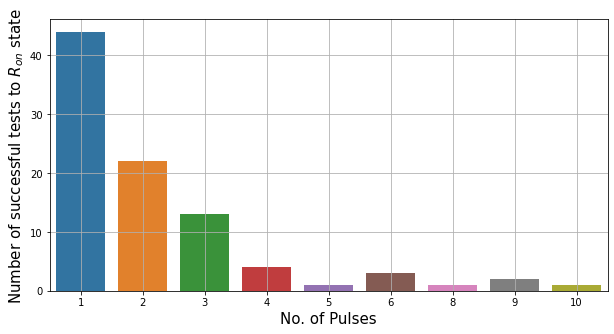

In [22]:

temp_data = data[data["isSucces"]==True].groupby(by="Pulses").count()
plt.figure(figsize=(10,5))
sns.barplot( x=temp_data.index,y="R", data=temp_data)
plt.xlabel("No. of Pulses", fontsize=15)
plt.ylabel("Number of successful tests to $R_{on}$ state ", fontsize=15)
plt.grid(True)

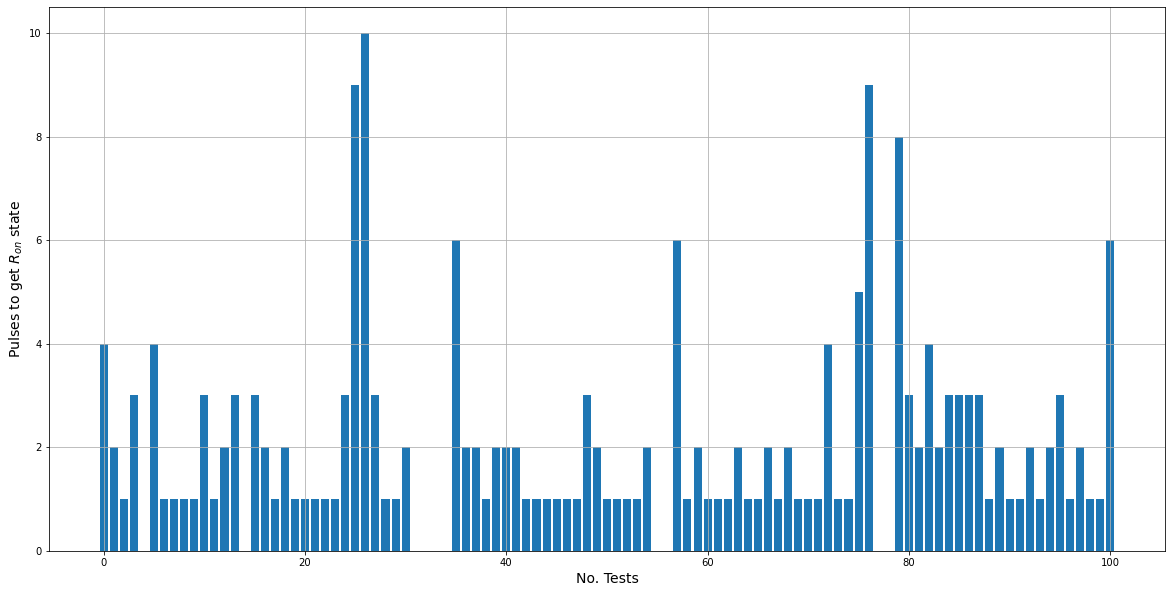

In [23]:
temp_data = data[data["isSucces"]==True]
plt.figure(figsize=(20,10))
plt.bar(x=temp_data["Tests"], height=temp_data["Pulses"],width=0.8)
plt.xlabel("No. Tests",fontdict={'fontsize':14})
plt.ylabel("Pulses to get $R_{on}$ state",fontdict={'fontsize':14})
plt.grid(True)




In [24]:
data['Q_integrated'] = np.nan
data['E_integrated'] = np.nan



for i in data.index:
    if data.loc[i,"q"] == 0:
        data.loc[i,"Q_integrated"] = 0
    else:
        data.loc[i,"Q_integrated"] = data.loc[i-1,"Q_integrated"]+data.loc[i,"q"]
    if data.loc[i,"E_memristor"] == 0:
        data.loc[i,"E_integrated"] = 0
    else:
        data.loc[i,"E_integrated"] = data.loc[i-1,"E_integrated"]+data.loc[i,"E_memristor"]

data['Q_integrated']





0      0.000000
1      0.001459
2      0.002894
3      0.004329
4      0.005771
         ...   
398    0.002901
399    0.004335
400    0.005764
401    0.007180
402    0.008617
Name: Q_integrated, Length: 403, dtype: float64

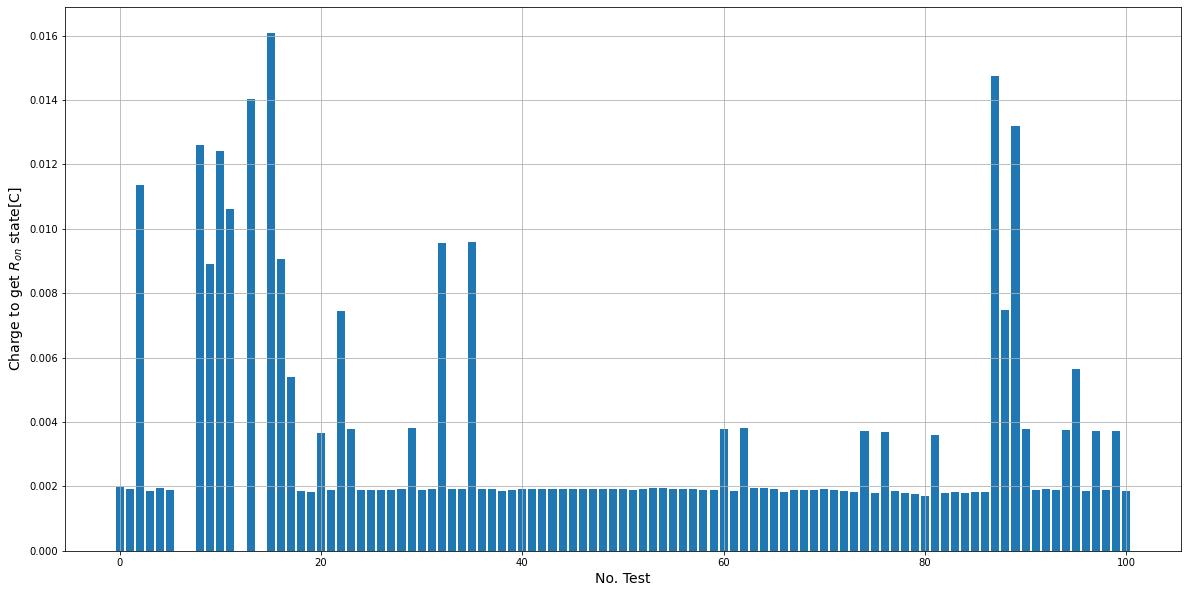

In [11]:
temp_data = data[data["isSucces"]==True]
plt.figure(figsize=(20,10))
plt.bar(x=temp_data["Tests"], height=temp_data["Q_integrated"],width=0.8)
plt.xlabel("No. Test",fontdict={'fontsize':14})
plt.ylabel("Charge to get $R_{on}$ state[C]",fontdict={'fontsize':14})
plt.grid(True)



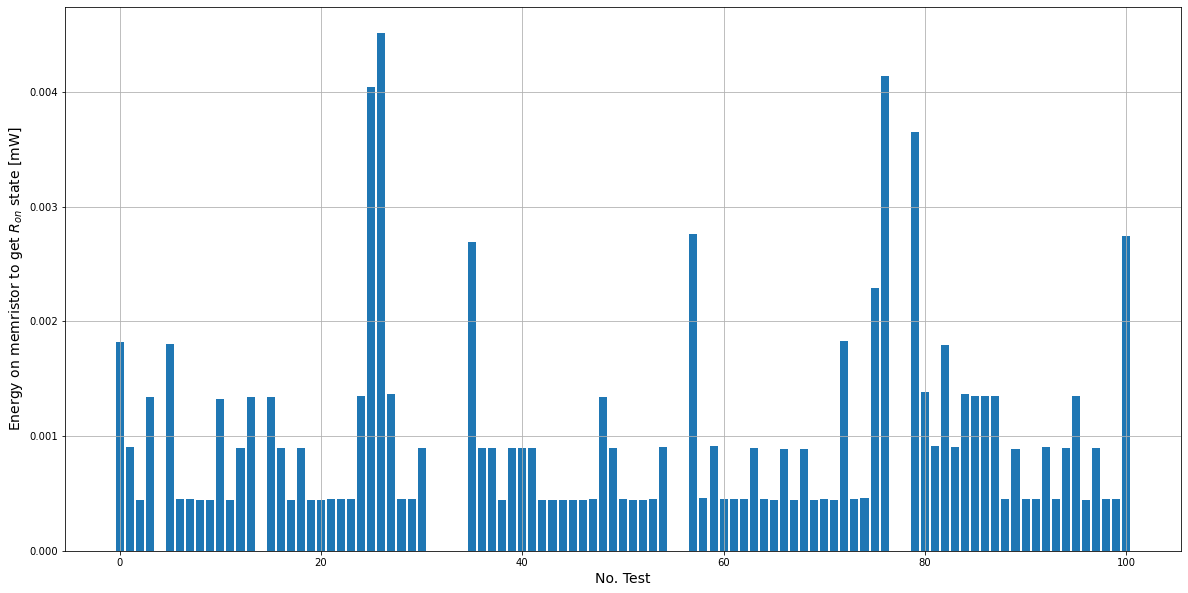

In [25]:

temp_data = data[data["isSucces"]==True]
plt.figure(figsize=(20,10))
plt.bar(x=temp_data["Tests"], height=temp_data["E_integrated"],width=0.8,)
plt.xlabel("No. Test",fontdict={'fontsize':14})
plt.ylabel("Energy on memristor to get $R_{on}$ state [mW]",fontdict={'fontsize':14})
plt.grid(True)


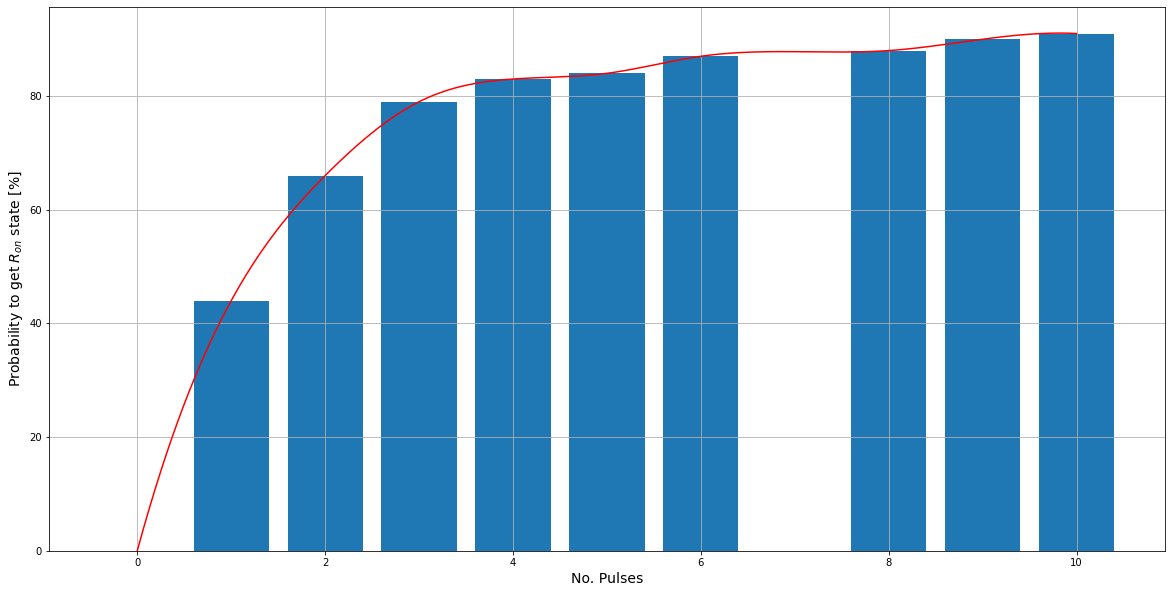

In [26]:
import plotly.express as px
from scipy.interpolate import interp1d

number_of_tests = np.max(data["Tests"])

temp_data = data[data["isSucces"]==True].groupby(by="Pulses",as_index=False).count()
temp_data['Probability'] = np.multiply(temp_data['R'],1/number_of_tests)
temp_data.reset_index(inplace=True)
P = 0
for i in temp_data.index:
    P = temp_data.loc[i,'Probability']+P
    temp_data.loc[i,'Probability'] = P
x = temp_data['Pulses'].to_numpy()
x = np.insert(x,0,0)
y = temp_data['Probability'].to_numpy()
y = np.insert(y,0,0)*100

plt.figure(figsize=(20,10))
plt.bar(x=x, height=y,width=0.8)
plt.xlabel("No. Pulses",fontdict={'fontsize':14})
plt.ylabel("Probability to get $R_{on}$ state [%]",fontdict={'fontsize':14})
plt.grid(True)
x_i = np.arange(start= np.min(x),stop= np.max(x),step=0.001)

cs = interp1d(x, y,kind='cubic')
plt.plot(x_i, cs(x_i),'r')


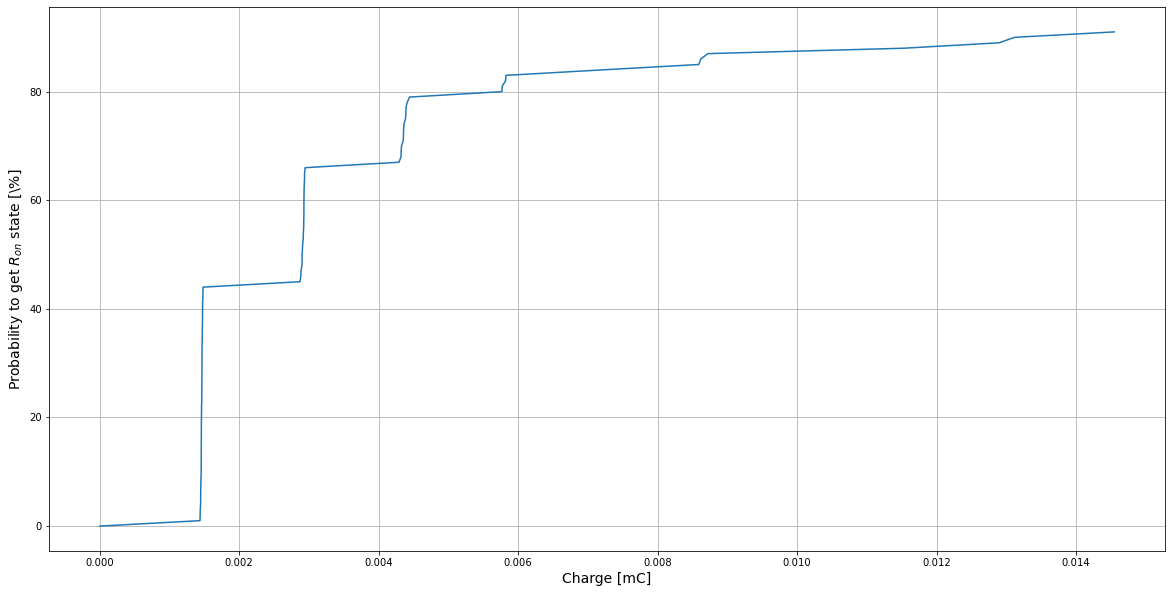

In [27]:

number_of_tests = np.max(data["Tests"])

temp_data = data[data["isSucces"]==True].groupby(by="Q_integrated",as_index=False).count()
temp_data.sort_values(by="Q_integrated",ascending=True,inplace=True)
temp_data.reset_index(drop=True,inplace=True)
temp_data

temp_data['Probability'] = np.multiply(temp_data['R'],1/number_of_tests)
P = 0

for i in temp_data.index:
    P = temp_data.loc[i,'Probability']+P
    temp_data.loc[i,'Probability'] = P

x = temp_data['Q_integrated'].to_numpy()
x = np.insert(x,0,0)
y = temp_data['Probability'].to_numpy()
y = np.insert(y,0,0)*100

plt.figure(figsize=(20,10))
plt.plot(x, y)
plt.xlabel("Charge [mC]",fontdict={'fontsize':14})
plt.ylabel("Probability to get $R_{on}$ state [\%]",fontdict={'fontsize':14})
plt.grid(True)
x_i = np.arange(start= np.min(x),stop= np.max(x),step=0.001)

cs = interp1d(x, y,kind='previous')
#plt.plot(x_i, cs(x_i),'r')




In [36]:
temp_data 

,Q_integrated,Time,Pulses,Tests,R,isSucces,dt_Ron,Amp_Ron,q,E_memristor,State,E_integrated,Probability
0,0.001711,1,1,1,1,1,1,1,1,1,1,1,0.01
1,0.001779,1,1,1,1,1,1,1,1,1,1,1,0.02
2,0.001786,1,1,1,1,1,1,1,1,1,1,1,0.03
3,0.001787,1,1,1,1,1,1,1,1,1,1,1,0.04
4,0.001805,1,1,1,1,1,1,1,1,1,1,1,0.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,0.012617,1,1,1,1,1,1,1,1,1,1,1,0.93
93,0.013203,1,1,1,1,1,1,1,1,1,1,1,0.94
94,0.014046,1,1,1,1,1,1,1,1,1,1,1,0.95
95,0.014730,1,1,1,1,1,1,1,1,1,1,1,0.96
